In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold,cross_val_score, cross_val_predict,train_test_split, GridSearchCV
import nltk
import string
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, f1_score,accuracy_score
nltk.download('stopwords')
stopwords = set(stopwords.words('french'))
from nltk.stem.snowball import FrenchStemmer
import itertools
from sklearn.metrics import f1_score, make_scorer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/rym/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rym/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preprocessing des données

### Chargement des bases train et tests dans des numpy array

In [2]:
import re
def load_corpus_train(path):
    with open(path) as f:
        s = f.readline()
        labels = []
        texts = []
        while s:
            lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",s)
            txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",s)
            if 'M' in lab:
                labels.append(-1)
            else:
                labels.append(1)
            texts.append(txt[:-1])
            s = f.readline()

    labels = np.asarray(labels)    
    texts = np.asarray(texts)
    return texts, labels

def load_corpus_test(path): 
    with open(path,'rb') as f:
        s = f.readlines()
        texts = []
        for line in s:
            line = line.decode('utf-8')
            txt = re.sub(r"<[0-9]*:[0-9]*>(.*)","\\1",line)
            texts.append(txt.replace('\n',""))
    texts = np.asarray(texts)
    return texts

In [3]:

def chargementDonnées():
    texts, labels = load_corpus_train("corpus.tache1.learn.utf8")
    test_text = load_corpus_test("corpus.tache1.test.utf8")
    return texts,labels,test_text

In [4]:
texts,labels,test_text = chargementDonnées()

## Analyse Dimensionnelle et échantillonage

In [5]:
print ("La taille de la base train est :",labels.size)
print ("La taille de la base test est :",test_text.size)
print ("Le nombre d'entrées labelisées -1 (Mitterand) est :",np.where(labels==-1)[0].size,",soit :",np.where(labels==-1)[0].size*100/labels.size," %")
print ("Le nombre d'entrées labelisées 1 (Chirac) est :",np.where(labels==1)[0].size,",soit :",np.where(labels==1)[0].size*100/labels.size," %")


La taille de la base train est : 57413
La taille de la base test est : 27162
Le nombre d'entrées labelisées -1 (Mitterand) est : 7523 ,soit : 13.103304129726716  %
Le nombre d'entrées labelisées 1 (Chirac) est : 49890 ,soit : 86.89669587027328  %


In [6]:
def echantillonage(texts,labels,n=10000):
        texts = texts[:n]
        labels = labels[:n]
        return texts, labels

## Filtrage et ajout de nouveaux attributs

In [7]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [8]:
def pretraitement (texts,stemming=False,remove_stopwords=False):
  texts2 = []
  lengths = [len (t) for t in texts]
  nb_digits = []
  mean_len_words = []
  stemmer = FrenchStemmer()
  for t in texts :
      row = []
      nb_digits.append(sum(c.isdigit() for c in t))
      tokens = nltk.word_tokenize(t,language="french")
      if remove_stopwords:
        row = [stemmer.stem(w) for w in tokens if len(w)>1 and w not in stopwords] if stemming else [w for w in tokens if len(w)>1 and w not in stopwords]
      else:
        row = [stemmer.stem(w) for w in tokens if len(w)>1] if stemming else [w for w in tokens if len(w)>1]
      texts2.append(" ".join(row))
      mean_len_words.append(sum([len(tok) for tok in tokens if tok.isalpha()])/len(tokens)) if len(row)>0 else mean_len_words.append(0)
  return np.array(texts2), lengths, np.array(nb_digits) , mean_len_words


In [9]:
texts_preprocessed, lengths, nb_digits , mean_len_words = pretraitement(texts,remove_stopwords=True)

In [10]:
word_mean_mitt = np.mean([mean_len_words[i] for i in range(len(labels)) if labels[i]==-1])
word_mean_chirac = np.mean([mean_len_words[i] for i in range(len(labels)) if labels[i]==1])

len_mean_mitt = np.mean([lengths[i] for i in range(len(labels)) if labels[i]==-1])
len_mean_chirac = np.mean([lengths[i] for i in range(len(labels)) if labels[i]==1])

mean_digits_mitt = np.mean([nb_digits[i] for i in range(len(labels)) if labels[i]==-1])
mean_digits_chirac = np.mean([nb_digits[i] for i in range(len(labels)) if labels[i]==1])

print("Le nombre moyen de mots par discours pour Chirac est : ",len_mean_chirac)
print("Le nombre moyen de mots par discours pour Mitterand est : ",len_mean_mitt)

print("La moyenne des tailles moyennes de mots par discours (avant stemming) pour Chirac est : ",word_mean_chirac)
print("La moyenne des tailles moyennes de mots par discours (avant stemming) pour Mitterand est : ",word_mean_mitt)

print("La moyenne des chiffres par discours pour Chirac est : ",mean_digits_mitt)
print("La moyenne des chiffres par discours pour Mitterand est : ",mean_digits_chirac)


Le nombre moyen de mots par discours pour Chirac est :  131.2489677290038
Le nombre moyen de mots par discours pour Mitterand est :  163.2318224112721
La moyenne des tailles moyennes de mots par discours (avant stemming) pour Chirac est :  3.9946139840701527
La moyenne des tailles moyennes de mots par discours (avant stemming) pour Mitterand est :  3.735804395369358
La moyenne des chiffres par discours pour Chirac est :  0.20922504320085072
La moyenne des chiffres par discours pour Mitterand est :  0.10330727600721587


## Nombre de mots en fonction du min_df

In [11]:
min_df = [1,2,3,4,5,6,7,8,9,10]
nb_mots = []
for m in min_df:
  vect = CountVectorizer(min_df=m).fit(texts)
  nb_mots.append(len(vect.get_feature_names()))
nb_mots

[28524, 18001, 14153, 11958, 10478, 9405, 8613, 7951, 7394, 6938]

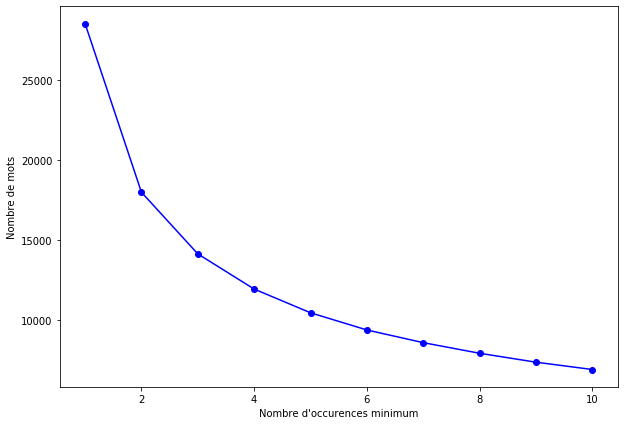

In [12]:
plt.figure(figsize=(10,7))
plt.plot(min_df, nb_mots, '-bo')
#plt.title("Nombre de mots gardés en fonction du nombre minimum d'apparitions dans la base")
plt.ylabel('Nombre de mots')
plt.xlabel('Nombre d\'occurences minimum')
plt.savefig("Nombre de mots gardés en fonction du nombre minimum d'apparitions dans la base.jpg")

# Classification

## Naive Bayes et Optimisation alpha

In [ ]:
vect = CountVectorizer(min_df=2).fit(texts_preprocessed)
texts_vectorized = vect.transform(texts_preprocessed)
alphas = [0,0.01,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
mean_f1 = []
for a in alphas:
  clf =  MultinomialNB(alpha=a)
  clf.fit(texts_vectorized, labels)
  scores = cross_val_score(clf, texts_vectorized, labels, cv=5,scoring=make_scorer(f1_score,pos_label=-1))
  mean_f1.append(np.mean(scores))


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

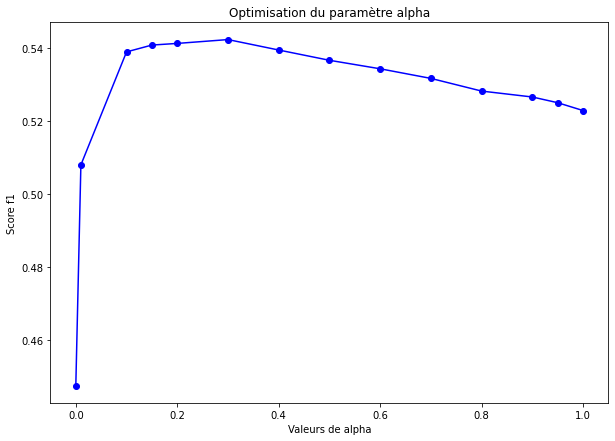

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(alphas, mean_f1, '-bo')
plt.title("Optimisation du paramètre alpha")
plt.ylabel('Score f1')
plt.xlabel('Valeurs de alpha')
plt.savefig("Optimisation du paramètre alpha.jpg")

## Optimisation du paramètre de régularisation C pour LinearSVM et LogisticRegression

In [ ]:
vect = CountVectorizer(min_df=2).fit(texts_preprocessed)
texts_vectorized = vect.transform(texts_preprocessed)
C = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [ ]:
param_grid = {'C': [0.01,0.1,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
vect = CountVectorizer(min_df=2).fit(texts_preprocessed)
texts_vectorized = vect.transform(texts_preprocessed)
grid1 = GridSearchCV(LinearSVC(max_iter=10000),param_grid,refit=True,verbose=0,scoring=make_scorer(f1_score,pos_label=-1))
grid1.fit(texts_vectorized,labels)



GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, pos_label=-1), verbose=0)

In [ ]:
print(grid1.best_estimator_)

LinearSVC(C=0.4, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [ ]:
grid2 = GridSearchCV(LogisticRegression(max_iter=10000),param_grid,refit=True,verbose=0,scoring=make_scorer(f1_score,pos_label=-1))
grid2.fit(texts_vectorized,labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, pos_label=-1), verbose=0)

In [ ]:
print(grid2.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


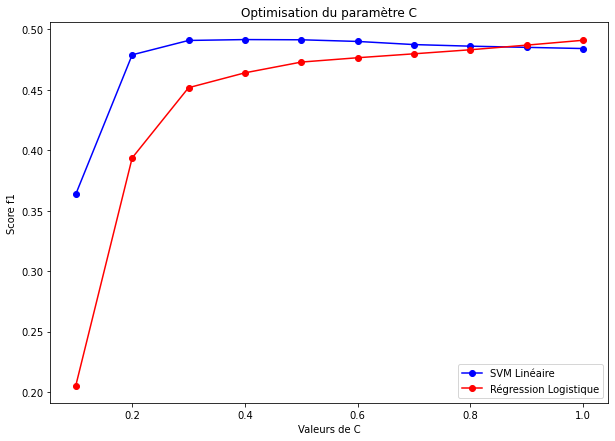

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(C, grid1.cv_results_['mean_test_score'], '-bo',label="SVM Linéaire")
plt.plot(C, grid2.cv_results_['mean_test_score'], '-ro',label="Régression Logistique")
plt.title("Optimisation du paramètre C")
plt.ylabel('Score f1')
plt.xlabel('Valeurs de C')
plt.legend()
plt.savefig("Optimisation du paramètre C.jpg")

#Post Processing

### Smoothing

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def smooth_knn(y):
  X= np.arange(len(y)).reshape((len(y),1))
  neigh = KNeighborsClassifier(n_neighbors=10)
  neigh.fit(X, y)
  return neigh.predict(X)

In [ ]:
def smooth_simple(prediction):
  pred = prediction.copy()
  if pred[0]!=pred[1] and pred[0]!=pred[2]:
    pred[0] = pred[1]
  for i in range(1,len(pred)-1):
    if pred[i] != pred[i-1] and pred[i] != pred[i+1]:
      pred[i] = pred[i-1] 
  if pred[-1]!=pred[-2]:
    pred[-1] = pred[-2]
  return pred

In [ ]:
def cross_validation_smooth (clf,texts2,nb_digits,add_features,smooth,bigrams,verbose=False,nfolds=5):
  kf = KFold(n_splits=nfolds)
  accuracy_scores = []
  accuracy_scores_lisse = []
  f1_scores_before = []
  f1_scores_after = []
  for train_index, test_index in kf.split(labels):
    X_train, X_test = texts2[train_index], texts2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    digits_train, digits_test = nb_digits[train_index], nb_digits[test_index]
    if bigrams :
      vect = CountVectorizer(min_df=3,ngram_range=(1,2)).fit(X_train)
    else:
      vect = CountVectorizer(min_df=3).fit(X_train)
    texts_vectorized = vect.transform(X_train)
    if add_features :
      texts_vectorized= add_feature(texts_vectorized,digits_train)

    clf.fit(texts_vectorized, y_train)
    if add_features:
      y_pred = clf.predict(add_feature(vect.transform(X_test),digits_test))
    else:
      y_pred = clf.predict(vect.transform(X_test))
    accuracy_scores.append(accuracy_score(y_test,y_pred))
    accuracy_scores_lisse.append(accuracy_score(y_test,smooth_simple(smooth(y_pred))))
    f1_scores_before.append(f1_score(y_test,y_pred, pos_label=-1))
    f1_scores_after.append(f1_score(y_test,smooth_simple(smooth(y_pred)), pos_label=-1))
    if verbose :
      print("mesure f1 avant lissage :",f1_score(y_test, y_pred, pos_label=-1))
      print("mesure f1 après lissage :",f1_score(y_test,smooth(y_pred), pos_label=-1))
      print("***********")
      print("accuracy avant lissage :",accuracy_score(y_test,y_pred))
      print("accuracy après lissage :",accuracy_score(y_test,smooth(y_pred)))
      print("**********************************")
  if verbose :
    print("moyenne f1 avant :",np.mean(f1_scores_before))
    print("moyenne f1 après :",np.mean(f1_scores_after))

  return accuracy_scores, accuracy_scores_lisse, f1_scores_before,f1_scores_after

In [ ]:
texts_preprocessed, lengths, nb_digits , mean_len_words = pretraitement(texts,remove_stopwords=True)
clf = MultinomialNB(alpha=0.4)
accuracy_scores, accuracy_scores_lisse, f1_scores_before,f1_scores_after = cross_validation_smooth (clf,texts_preprocessed,nb_digits,True,smooth_knn,True)

In [ ]:
np.mean(f1_scores_after)

### Remplissage du tableau de tests

In [ ]:
def tests (Stopwords=False,add_features=False,Stemming=False,ngrams=False):
  print(Stopwords,add_features,ngrams)
  texts2, lengths, nb_digits , mean_len_words = pretraitement(texts,remove_stopwords=not(Stopwords),stemming=Stemming)
  clf = MultinomialNB(alpha=0.4)
  accuracy_scores, accuracy_scores_lisse, f1_scores_before,f1_scores_after = cross_validation_smooth (clf,texts2,nb_digits,add_features,smooth_knn,ngrams)
  #print("NB accuracy sans lissage:",np.mean(accuracy_scores))
  #print("NB accuracy avec lissage:",np.mean(accuracy_scores_lisse))
  print("NB f1 sans lissage:",np.mean(f1_scores_before))
  print("NB f1 avec lissage:",np.mean(f1_scores_after))
  clf =  LogisticRegression(max_iter=10000)
  #clf.fit(texts_vectorized, labels)
  accuracy_scores, accuracy_scores_lisse, f1_scores_before,f1_scores_after = cross_validation_smooth (clf,texts2,nb_digits,add_features,smooth_knn,ngrams)
  #print("LR accuracy sans lissage:",np.mean(accuracy_scores))
  #print("LR accuracy avec lissage:",np.mean(accuracy_scores_lisse))
  print("LR f1 sans lissage:",np.mean(f1_scores_before))
  print("LR f1 avec lissage:",np.mean(f1_scores_after))
  clf =  LinearSVC(C=0.4,max_iter=10000)
  #clf.fit(texts_vectorized, labels)
  accuracy_scores, accuracy_scores_lisse, f1_scores_before,f1_scores_after = cross_validation_smooth (clf,texts2,nb_digits,add_features,smooth_knn,ngrams)
  #print("SVM accuracy sans lissage:",np.mean(accuracy_scores))
  #print("SVM accuracy avec lissage:",np.mean(accuracy_scores_lisse))
  print("SVM f1 sans lissage:",np.mean(f1_scores_before))
  print("SVM f1 avec lissage:",np.mean(f1_scores_after))

In [ ]:
for stp in [False,True]:
  for add_feat in [False,True]:
      for ng in [False,True]:
        print("************************************")
        tests(Stopwords=stp,add_features=add_feat,Stemming=False,ngrams=ng)

************************************
False False False
NB f1 sans lissage: 0.5317374761516375
NB f1 avec lissage: 0.6218857433796889
LR f1 sans lissage: 0.47999346492109957
LR f1 avec lissage: 0.46582994654145365
SVM f1 sans lissage: 0.47567049759682545
SVM f1 avec lissage: 0.504484920970941
************************************
False False True
NB f1 sans lissage: 0.5607497165861391
NB f1 avec lissage: 0.680241789333882
LR f1 sans lissage: 0.5157595416965072
LR f1 avec lissage: 0.5107123690680478
SVM f1 sans lissage: 0.5137902827212043
SVM f1 avec lissage: 0.5598744891099212
************************************
False True False
NB f1 sans lissage: 0.5302490426447279
NB f1 avec lissage: 0.6212894205481128
LR f1 sans lissage: 0.4813099496826202
LR f1 avec lissage: 0.468625439202403
SVM f1 sans lissage: 0.4763394925185972
SVM f1 avec lissage: 0.5060732964138663
************************************
False True True
NB f1 sans lissage: 0.5608521522774005
NB f1 avec lissage: 0.681954730943231

# Test à envoyer 

In [ ]:
texts2, lengths, nb_digits , mean_len_words = pretraitement(texts,remove_stopwords=False,stemming=False)
vect = CountVectorizer(min_df=3,ngram_range=(1,2)).fit(texts2)
texts_vectorized = vect.transform(texts2)
texts_vectorized= add_feature(texts_vectorized,nb_digits)
clf = MultinomialNB(alpha=0.4)
clf.fit(texts_vectorized, labels)
f1_score(labels,smooth_simple(smooth_knn(clf.predict(texts_vectorized))),pos_label=-1)

0.9117112438327706

In [ ]:
accuracy_score(labels,smooth_simple(smooth_knn(clf.predict(texts_vectorized))))

0.9763119850904848

In [ ]:
feature_names = np.concatenate((vect.get_feature_names(),["nb_digits"]))
sorted_coef_index = clf.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))
#plot_coefficients(clf, feature_names)

Smallest Coefs:
['faut tenter' 'reste quelques' 'on discute' 'mais lorsqu' 'voulais pas'
 'estampes' 'crise mondiale' 'toute femme' 'on dirait' 'bretagne italie'
 'que dis' 'européenne on' 'faire bien' 'esthétique la' 'en chemin'
 'on dira' 'bretagne la' 'quiconque se' 'formé aux' 'très partisan']

Largest Coefs: 
['de' 'la' 'et' 'le' 'les' 'des' 'est' 'en' 'qui' 'que' 'une' 'un' 'pour'
 'de la' 'dans' 'du' 'je' 'nous' 'vous' 'il']


In [ ]:
texts2, lengths, nb_digits , mean_len_words = pretraitement(test_text,remove_stopwords=False,stemming=False)
texts_vectorized = add_feature(vect.transform(texts2),nb_digits)
predictions = clf.predict(texts_vectorized)
predictions = smooth_simple(smooth_knn(predictions))
with open('data',"w") as f:
  for p in predictions:
    data = f.write(str(p)+"\n")